In [1]:
#-*-coding:utf-8-*-

%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torchvision

import cv2

import copy

import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
%matplotlib inline

__ROOT_PATH = os.path.abspath('../../')
sys.path.append(__ROOT_PATH)

matplotlib.rcParams['figure.facecolor'] = 'w'

In [2]:
from scgan.loader.colored_mnist_loader import ColoredMnistDataset
from scgan.model.scseparator_model import SCSeparatorMnistModel

In [3]:
DATA_ROOT = os.path.join(__ROOT_PATH, "data/")
RUN_ROOT = os.path.join(__ROOT_PATH, "runs/")

In [11]:
run_dir = os.path.join(RUN_ROOT, "mnist_sc_separate/")
os.makedirs(run_dir, exist_ok=True)

#params = {'seed': 2222, 'num_epoch': 100, 'batch_size': 64, 'test_batch_size': 512,
#          'learning_rate': 0.001, 'scheduler_gamma': 0.99, 'weight_decay': 0.0001,# 'clip_size': 3.,
#          'lambda_idt': 1., 'lambda_cycle': 0.01, 'lambda_content': 0.01, 'lambda_style': 0.01, 'lambda_siamese': 1.,
#          'gamma_content': 1., 'gamma_style': 1.,
#          'scheduler_interval': 1000, 'checkpoint_interval': 10,
#          'validation_interval': 10, 'logging_interval': 10, 'sampling_interval': 100,
#          'stopping_loss': 'loss',
#          'run_dir': run_dir}
params = {'seed': 2222, 'num_epoch': 200, 'batch_size': 32, 'test_batch_size': 512,
          'learning_rate': 0.001, 'scheduler_gamma': 0.98, 'weight_decay': 0.00001,# 'clip_size': 3.,
          'lambda_identity': 1., 'lambda_cycle': 1., 'lambda_weight_cycle': 1.,
          'lambda_content': 0.05, 'lambda_style': 0.05, 'lambda_siamese': 1.,
          'gamma_content': 0.2, 'gamma_style': 0.2,
          'scheduler_interval': 1000, 'checkpoint_interval': 10,
          'validation_interval': 10, 'logging_interval': 10, 'sampling_interval': 100,
          'stopping_loss': 'loss',
          'run_dir': run_dir}

In [5]:
train_dataset = ColoredMnistDataset(root=DATA_ROOT, train=True)
test_dataset = ColoredMnistDataset(root=DATA_ROOT, train=False)
print(len(train_dataset), len(test_dataset))

60000 10000


In [6]:
train_loader = DataLoader(train_dataset, params['batch_size'], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, params['test_batch_size'], shuffle=False, drop_last=False)
print(len(train_loader), len(test_loader))

1875 20


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sc_model = SCSeparatorMnistModel(device)
#sc_model.load(os.path.join(run_dir, 'best_model.pth.tar'))
sc_model.train_model(train_loader, params=params)


Learning with learning rate:  0.00100000.

[1/200] 10'th step. [LOSS] 1.159991. [LOSS_IDENTITY] 0.220537. [LOSS_CYCLE] 0.221647. [LOSS_WEIGHT_CYCLE] 0.475830. [LOSS_CONTENT] 0.036946. [ACCURACY_CONTENT] 0.453125. [LOSS_STYLE] 0.035946. [ACCURACY_STYLE] 0.515625. [LOSS_SIAMESE] 0.169084. [NORM_S1] 0.508342. [NORM_S2] 0.765571
    Best Step:     10. Elapsed Time: 6.191446 seconds.
[1/200] 20'th step. [LOSS] 0.861739. [LOSS_IDENTITY] 0.178559. [LOSS_CYCLE] 0.201502. [LOSS_WEIGHT_CYCLE] 0.313122. [LOSS_CONTENT] 0.036177. [ACCURACY_CONTENT] 0.484375. [LOSS_STYLE] 0.036205. [ACCURACY_STYLE] 0.500000. [LOSS_SIAMESE] 0.096173. [NORM_S1] 0.370893. [NORM_S2] 1.011251
    Best Step:     20. Elapsed Time: 7.396224 seconds.
[1/200] 30'th step. [LOSS] 0.664339. [LOSS_IDENTITY] 0.135892. [LOSS_CYCLE] 0.154432. [LOSS_WEIGHT_CYCLE] 0.239952. [LOSS_CONTENT] 0.035454. [ACCURACY_CONTENT] 0.546875. [LOSS_STYLE] 0.035534. [ACCURACY_STYLE] 0.421875. [LOSS_SIAMESE] 0.063074. [NORM_S1] 0.324659. [NORM_S2] 1.2

In [8]:
all_input, all_output = sc_model.predict(test_loader)

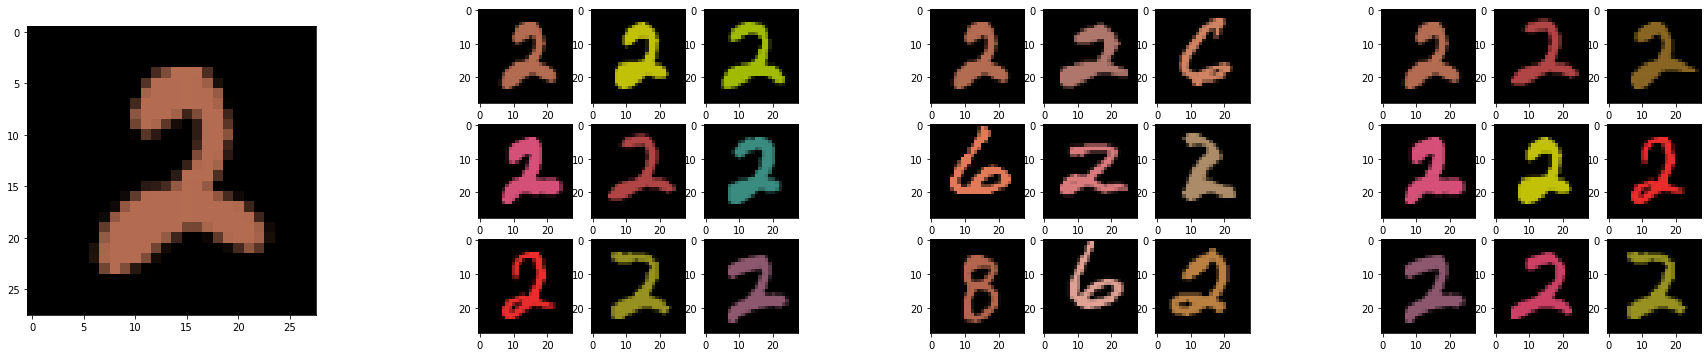

In [14]:
images = all_input['x2'].numpy().transpose(0, 2, 3, 1)
latents = all_output['z2'].numpy()
styles = all_output['s2'].numpy()
contents = all_output['c2'].numpy()

index = np.random.randint(len(images))

fig = plt.figure(figsize=(30, 6))

ax = fig.add_subplot(1, 5, 1)
ax.imshow(images[index])
content_indices = ((contents-contents[index:index+1])**2).mean(axis=1).argsort(axis=0)
style_indices = ((styles-styles[index:index+1])**2).mean(axis=1).argsort(axis=0)
latent_indices = ((latents-latents[index:index+1])**2).mean(axis=1).argsort(axis=0)
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+5)
    ax.imshow(images[content_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+9)
    ax.imshow(images[style_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+13)
    ax.imshow(images[latent_indices[i]])

plt.savefig(os.path.join(__ROOT_PATH, "./results/", f"similar_test.png"), dpi=200, bbox_inches='tight')
plt.show()